#### Introduction
This notebook aims to simulate NWP-based power forecasting datasets by generating time series with synthetic novelties and anomalies. The time series is used to evaluate and compare deep novelty detection techniques. The generative process should be controllable and customizable, including the number of samples, the type and number of anomalies, the specific dimension in which anomalies appear, the mapping function, etc.

By considering the periodicity and stochasticity, the generative function of multivariate input time series combines periodic functions with Gaussian noise.
The generation of a univariate input time series can be described as follows:
\begin{align}
    x\left(t\right) & = f\left(t\right) + \epsilon \\
                                & = \sum_{n=1}^{N}A_{n}f^{(n)}_{T_{n}}\left(t\right) + \epsilon,
    \label{eq:artifical_ts}
\end{align}
where the amplitude $A_n$, the type of periodical function $f^{(n)}_{T_{n}}$ with the period $T_{n}$, and the amount of functions $N$ can be customized according to requirement. By combining multiple input time series, we can get a dataset of non-stationary multivariate time series. We define $X^{I \times J}$ as a $J$-dimensional with $I$ samples. Then, $X_{t, :}= \mathbf{x}(t)=[x_1\left(t\right), x_2\left(t\right), ..., x_J\left(t\right)]$ denotes the $t$-th sample in the data set, i.e., the input vector obtained at the time point $t$.

The mapping function can also be designed according to requirement, i.e., $\mathbf{y}\left(t\right)=f(\mathbf{x}\left(t\right))$, where $f\left(\cdot\right)$ can be linear or nonlinear.

In [263]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import randn
from sklearn.preprocessing import MinMaxScaler
import copy

import seaborn as sns

#### Hyperparameters of Nonstationary Time Series
- Dimension of input X: 5
- Dimension of output y: 1
- Duration: 730 days (2 years)
- Unit of time step: 1 = 1 min
- Period of day: $T_d = \frac{\mathrm{24\ hours}}{\mathrm{1\ unit}}$
- Period of year: $T_y = \frac{\mathrm{365\ days}}{\mathrm{1\ unit}}$
- $j$-th univariate input time series: $x_j\left(t\right) = f_j\left(t\right) + \epsilon = A_{d}^{j}[sin\left(\frac{2 \pi t}{T_{d}} + \phi_d^{j}\right)+1] + A_{y}^{j}[sin\left(\frac{2 \pi t}{T_{y}} + \phi_y^{j}\right)+1] + \epsilon$, where $A^{j}$ and $\phi^{j}$ are randomly sampled from Gaussian distributions.
- Mapping function $f\left(\cdot\right)$: $y\left(t\right) = f(\mathbf{x}\left(t\right)) + \epsilon=\left[\frac{1}{J}\sum_{j=1}^{J}x_j\left(t\right)\right]^3 + \epsilon$
- Resolution: 10 units (10 mins)

In [130]:
# HYPERPARAMETERS
YEARS=2
DAYS=365*YEARS  # 730 days
UNIT=1  # 1 unit = 1 mins
PERIOD_D=24*60  #  one day period (number of units in one day)
PERIOD_Y=24*60*365  #  one year period (number of units in one year)
RESOLUTION=10*UNIT

time=np.arange(0, DAYS*PERIOD_D, UNIT)

In [131]:
def artificial_ts(time, periods, resolution, num_features, seed=12345):
    np.random.seed(seed)
    N = len(periods)
    
    param_ts = {'amplitude': [],
                    'phase':[]}
    X = []
    
    for j in range(num_features):
        amlitude = (randn(N)*[1, 10])+[5, 20]
        phase = randn(N)
        #phase = np.random.uniform(0,2*np.pi, 2) #another option to generate time series
        # x_j generation
        x_uni = [amlitude[i]*np.sin(2*np.pi*time/periods[i] + phase[i]) for i in range(N)]
        X.append(np.mean(x_uni, axis=0))
        
        param_ts['amplitude'].append(amlitude)
        param_ts['phase'].append(phase)

    y = np.mean(X, axis=0)**3
    
    
    X = np.array(X)[:,::resolution].T
    y = np.array(y).reshape(-1,1)[::resolution, :]
    
    X_noise = randn(X.shape[0], X.shape[1])
    X_noisy = X + X_noise
    y_noise = randn(y.shape[0], 1)*5
    y_noisy = y + y_noise
    
    time_series = np.concatenate((X, y), axis=1)
    time_series_noisy = np.concatenate((X_noisy, y_noisy), axis=1)
    
    return param_ts, np.float32(time_series), np.float32(time_series_noisy), np.float32(X_noise), np.float32(y_noise)

In [132]:
_, origin_ts, noisy_ts, noise_X, noise_y = artificial_ts(time, [PERIOD_D, PERIOD_Y], RESOLUTION, 5)

In [133]:
scaler = MinMaxScaler()
noisy_ts_scaled = scaler.fit_transform(X=noisy_ts)
origin_ts_scaled = scaler.transform(origin_ts)

noise_combined = np.concatenate((noise_X, noise_y), axis=1)
noise_combined_scaled = noise_combined/(scaler.data_max_-scaler.data_min_)
noise_X_scaled = noise_combined_scaled[:,:5]
noise_y_scaled = noise_combined_scaled[:,5:]

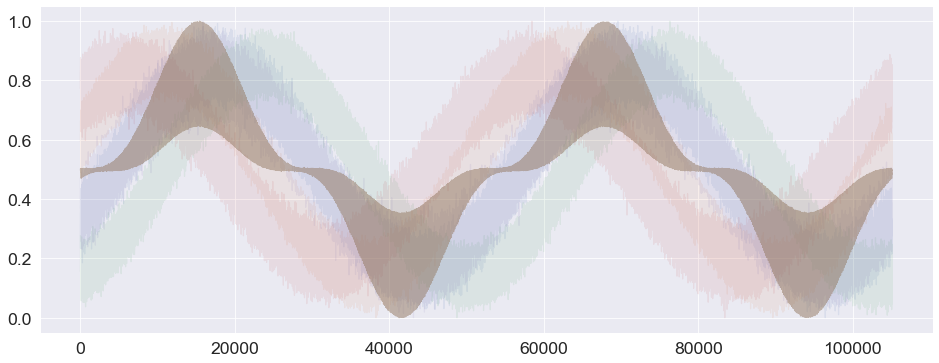

In [134]:
plt.figure(figsize=(16, 6))
plt.plot(noisy_ts_scaled[:,:5], alpha=0.1)
plt.plot(noisy_ts_scaled[:,5:], alpha=0.5)
plt.show()

#### Synthetic Anomalies
We define a  time series $x\left(t\right) = f\left(t\right) + \epsilon$, where $f\left(t\right)$ refers to the actual time series generated by the generative function $f\left(\cdot\right)$ and $x\left(t\right)$ refers to the observed (or measured) time series with noise.
$\epsilon \sim \mathcal{N}\left(0, \sigma^2\right)$ is the stationary noise, whose properties, i.e., the mean and the variance, do not vary over time, e.g., Gaussian noise is a series of random errors that are independently Gaussian-distributed.
In this case, the observation $x\left(t\right)$ also follows a Gaussian distribution, $x\left(t\right) \sim \mathcal{N}\left(f\left(t\right), \sigma^2\right)$
We think the stationary noise can be caused by observation error or measurement error, and is therefore usually not of interest to analysts.

Assumed that an anomalous pattern starts after the time point $t_0$ and lasts the $T$ duration.
The sequence $S_{anomaly} = \{\widetilde{x}\left(t \right) | t_0 <  t \leq t_0 + T_1, t \in \mathbb{N}\}$ is labeled as an anomaly, which can be formatted as
\begin{equation}
    \widetilde{x}\left(t \right) = x\left(t\right) + \widetilde{\epsilon}\left(t\right) = f\left(t\right) + \epsilon + \widetilde{\epsilon}\left(t\right).
    \label{eq:formatted_anomaly}
\end{equation}
$\widetilde{\epsilon}\left(t\right)$ is the non-stationary noise, which can be extended to the following specific formats:
\begin{align}
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\mu, \sigma^2 \right),\label{eq:non_stat_homo}\\
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\mu\left(t\right), \sigma^2 \right),\label{eq:non_stat_homo_moving}\\
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\mu, \sigma^2\left(t\right) \right),\label{eq:non_stat_hetero}\\
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\mu\left(t\right), \sigma^2\left(t\right) \right).\label{eq:non_stat_hetero_moving}
\end{align}
The variance of the first two formats is constant, corresponding to the non-stationary homoscedastic noise, and the variance of the last two formats varies over time, i.e., corresponding to the non-stationary heteroscedastic noise.
 

##### Examples of Synthetic Anomalies
The following specific synthetic anomalous time series are generated empirically:
\begin{align}
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\alpha \cdot f\left(t_0\right), \beta^2 \right),\\
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\alpha \cdot f\left(t\right) + b, \beta^2 \right),\\
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\alpha \cdot f\left(t_0\right), \beta^2\cdot\tau \right),\\
    \widetilde{\epsilon}\left(t\right) &\sim \mathcal{N}\left(\alpha \cdot \left(f\left(t_0\right)+\sqrt{\tau}\right) + b, \beta^2\cdot\tau\right).
\end{align}

Correspondingly, the anomalous time series follows the following Gaussian distributions:
\begin{align}
    \widetilde{x}\left(t\right) &\sim \mathcal{N}\left(f\left(t\right) + \alpha \cdot f\left(t_0\right), \sigma^2+\beta^2 \right),\\
    \widetilde{x}\left(t\right) &\sim \mathcal{N}\left(\left(1+\alpha\right)f\left(t\right) + b, \sigma^2+\beta^2 \right),\\
    \widetilde{x}\left(t\right) &\sim \mathcal{N}\left(f\left(t\right) + \alpha \cdot f\left(t_0\right), \sigma^2+\beta^2 \cdot \tau\right)\\
    \widetilde{x}\left(t\right) &\sim \mathcal{N}\left(f\left(t\right) + \alpha\left(f\left(t_0\right) + \sqrt{\tau}\right) + b, \sigma^2+\beta^2 \cdot \tau  \right),
\end{align}
where $\tau = t-t_0$

In [135]:
def add_synthetic_anomalies(origin_ts, params_configs, noise_X, noise_y):

    ts_output = copy.copy(origin_ts) # The final output time series with all added synthetic anomalies
    for params in params_configs:
        start_idx = params['start_idx']
        end_idx = params['end_idx']

        anomalous_sequence=ts_output[start_idx:end_idx, params['affected_channels']]

        alpha=params['alpha']
        beta=params['beta']
        b=params['b']
        increasing=params['increasing']

        gaussian_samples=np.random.randn(anomalous_sequence.shape[0], anomalous_sequence.shape[1])

        if params['anomaly_type'] == 1:
            non_noise = anomalous_sequence[0] * alpha + gaussian_samples*beta


        elif params['anomaly_type'] == 2:
            non_noise = anomalous_sequence *alpha + b + gaussian_samples*beta

        elif params['anomaly_type'] == 3:
            if increasing:
                tau = np.arange(1, anomalous_sequence.shape[0] + 1).reshape(-1, 1)
            else:
                tau = np.arange(anomalous_sequence.shape[0] , 0, -1).reshape(-1, 1)
            non_noise = anomalous_sequence[0] * alpha + beta*np.multiply(gaussian_samples, np.sqrt(tau))

        elif params['anomaly_type'] == 4:
            tau = np.arange(1, anomalous_sequence.shape[0] + 1).reshape(-1, 1)
            non_noise = alpha*(np.repeat(np.sqrt(tau), anomalous_sequence.shape[1], axis=1) + anomalous_sequence[0]) + b + beta*np.multiply(gaussian_samples, np.sqrt(tau))

        anomalous_sequence = anomalous_sequence+non_noise
        ts_output[start_idx:end_idx, params['affected_channels']] = anomalous_sequence

        if params['affected_channels'].tolist() !=[-1]:
            ts_output[start_idx:end_idx, [-1]] = (np.mean(ts_output[start_idx:end_idx, :-1], axis=1)).reshape(-1, 1)
            
    ts_output[:,:-1] += noise_X
    ts_output[:, -1:] += noise_y
    
    return ts_output

#### Add Synthetic Anomalies

Hyperparameters of adding synthetic anomalies:

- Types of anomalies: 4
- Amount of anomalies of each type: 50 (type 1-3), 10 (type 4)
- Duration of each anomaly: for type 1-3, between 12 hours (72 samples) and 48 hours (288 samples); for type 4, between 240 hours (1440 samples) and 360 hours (2160 samples)
- At least 2 channels are affected

In [136]:
def anomalies_idx_generation(num_anomalies:int, duration_range, num_samples):
    '''
    generate the indices of the selected type of the synthetic anomaly.
    params:
        - num_anomalies: int, the amount of anmalous sequences.
        - duration_range: np.array or list, the optional durations of an anomalous sequence.
        - num_samples: int, the amount of samples in the given dataset where anomalies will be added.
    '''
    duations_anomalies = np.random.choice(duration_range, num_anomalies)
    indices_samples = np.arange(num_samples)
    flag_anomalies = np.zeros_like(indices_samples)  # 0: no anomaly exists at the corresponding index

    counter = 0
    anomaly_indices = []
    
    while(counter<num_anomalies):
        start_index = np.random.choice(indices_samples, 1)[0]
        duration = duations_anomalies[counter]
        if sum(flag_anomalies[start_index:start_index+duration])==0 and start_index+duration<num_samples:
            flag_anomalies[start_index:start_index+duration] = 1
            anomaly_indices.append(np.arange(start_index,start_index+duration, 1))
            counter += 1
            
    return anomaly_indices

##### Experiment III-1
- Type 1: alpha=0.2, beta=0.05

In [264]:
NUM_ANOMALIES = 50  # Numbers of existing anomalies
CHANNELS=[0, 1, 2, 3, 4]  # on which input channels an anomaly happens
# The period of an anomaly ranges between half a day (12 hours) and 2 days (48 hours)
DURATION = np.arange(72, 288+1, 1)

anomaly_indices = anomalies_idx_generation(NUM_ANOMALIES, DURATION, int(noisy_ts_scaled.shape[0]/2))

In [272]:
params_configs=[]

for idx in range(NUM_ANOMALIES):
    selected_channels_num = np.random.choice(np.arange(2, 6), 1)
    # Type 1
    params={'index': idx,
            'affected_channels': np.sort(np.random.choice(CHANNELS, selected_channels_num, replace=False)),
            'anomaly_type': 1,
            'start_idx': anomaly_indices[idx][0],
            'end_idx': anomaly_indices[idx][-1],
            'alpha': 0.2,
            'beta': 0.05,
            'b': 0,
            'increasing': True,
           }
    params_configs.append(params)

In [273]:
warmup_length = int(origin_ts.shape[0]/2)
ts_anomaly_scaled = add_synthetic_anomalies(origin_ts_scaled[warmup_length:], params_configs, noise_X_scaled[warmup_length:], noise_y_scaled[warmup_length:])
ts_anomaly_scaled = np.concatenate((noisy_ts_scaled[:warmup_length], ts_anomaly_scaled), axis=0)

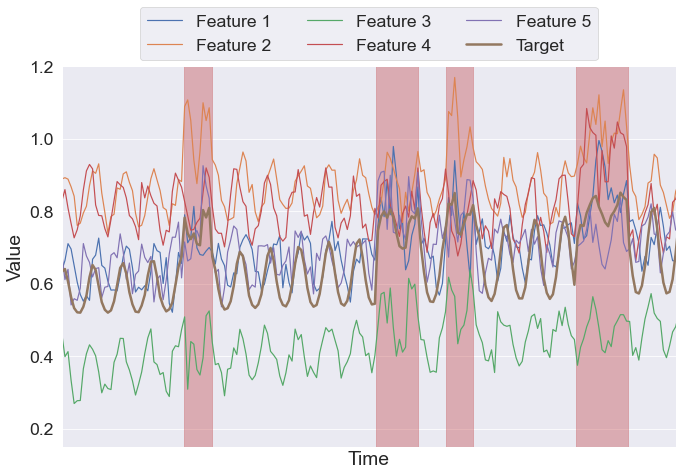

In [285]:
y_min = np.min(ts_anomaly_scaled[:,-1])-0.1
y_max = np.max(ts_anomaly_scaled[:,-1])+0.1
sns.set_theme(context='paper', font_scale=2)
plt.figure(figsize=(11, 7))
for i in range(5):
    plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, i], label= f'Feature {i+1}')
plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, -1], label= f'Target', linewidth=2.5)

plt.xlim((7500,10500))
plt.ylim((0.15, 1.2))
label_flag=[1,1,1,1]
for params in params_configs:
    start_idx=params['start_idx']
    end_idx=params['end_idx']
    if params['anomaly_type'] == 1:
        color='r'
        pattern_idx = params['anomaly_type']
        if label_flag[pattern_idx-1]:
            label = f'Pattern {pattern_idx}'
            label_flag[pattern_idx-1]=0
        else:
            label = '_nolegend_'
    plt.fill_between(np.arange(start_idx, end_idx), -0.3, 1.22, alpha=0.4, color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('./data_on_exp_I_1.pdf', dpi=300, bbox_inches='tight')

In [142]:
anomalous_sample_counter = 0
for params_idx, params in enumerate(params_configs):
    anomalous_sample_counter += params['end_idx'] - params['start_idx']

share = anomalous_sample_counter*2/origin_ts.shape[0]
print(f'share of outliers over the second-year data: {share*100:.2f} %')

share of outliers over the second-year data: 17.41 %


##### Experiment III-2
- Type 2: alpha=0.2, beta=0.05, b=0.05  

In [243]:
NUM_ANOMALIES = 50  # Numbers of existing anomalies
CHANNELS=[0, 1, 2, 3, 4]  # on which input channels an anomaly happens
# The period of an anomaly ranges between half a day (12 hours) and 2 days (48 hours)
DURATION = np.arange(72, 288+1, 1)

anomaly_indices = anomalies_idx_generation(NUM_ANOMALIES, DURATION, int(noisy_ts_scaled.shape[0]/2))

In [286]:
params_configs=[]

for idx in range(NUM_ANOMALIES):
    selected_channels_num = np.random.choice(np.arange(2, 6), 1)
    # Type 2
    params={'index': idx,
            'affected_channels': np.sort(np.random.choice(CHANNELS, selected_channels_num, replace=False)),
            'anomaly_type': 2,
            'start_idx': anomaly_indices[idx][0],
            'end_idx': anomaly_indices[idx][-1],
            'alpha': 0.2,
            'beta': 0.05,
            'b': 0.05,
            'increasing': True,
           }
    params_configs.append(params)

In [245]:
warmup_length = int(origin_ts.shape[0]/2)
ts_anomaly_scaled = add_synthetic_anomalies(origin_ts_scaled[warmup_length:], params_configs, noise_X_scaled[warmup_length:], noise_y_scaled[warmup_length:])
ts_anomaly_scaled=np.concatenate((noisy_ts_scaled[:warmup_length], ts_anomaly_scaled), axis=0)

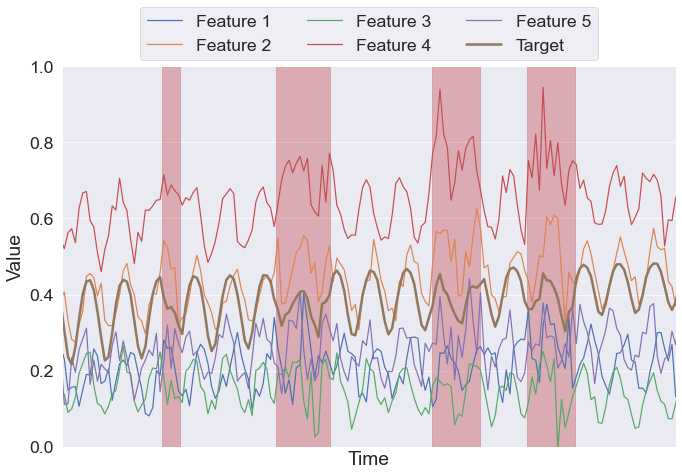

In [296]:
y_min = np.min(ts_anomaly_scaled[:,-1])-0.1
y_max = np.max(ts_anomaly_scaled[:,-1])+0.1
sns.set_theme(context='paper', font_scale=2)
plt.figure(figsize=(11, 7))
for i in range(5):
    plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, i], label= f'Feature {i+1}')
plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, -1], label= f'Target', linewidth=2.5)

plt.xlim((47000, 49500))
plt.ylim((-0., 1.0))
label_flag=[1,1,1,1]
for params in params_configs:
    start_idx=params['start_idx']
    end_idx=params['end_idx']
    if params['anomaly_type'] == 1:
        color='r'
        pattern_idx = params['anomaly_type']
        if label_flag[pattern_idx-1]:
            label = f'Pattern {pattern_idx}'
            label_flag[pattern_idx-1]=0
        else:
            label = '_nolegend_'
    plt.fill_between(np.arange(start_idx, end_idx), -0.3, 1.3, alpha=0.4, color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('./data_on_exp_I_2.pdf', dpi=300, bbox_inches='tight')

In [169]:
anomalous_sample_counter = 0
for params_idx, params in enumerate(params_configs):
    anomalous_sample_counter += params['end_idx'] - params['start_idx']

share = anomalous_sample_counter*2/origin_ts.shape[0]
print(f'share of outliers over the second-year data: {share*100:.2f} %')

share of outliers over the second-year data: 17.92 %


##### Experiment I-3
- Type 3: alpha=0.1, beta=0.01  

In [353]:
NUM_ANOMALIES = 50  # Numbers of existing anomalies
CHANNELS=[0, 1, 2, 3, 4]  # on which input channels an anomaly happens
# The period of an anomaly ranges between half a day (12 hours) and 2 days (48 hours)
DURATION = np.arange(72, 288+1, 1)

anomaly_indices = anomalies_idx_generation(NUM_ANOMALIES, DURATION, int(noisy_ts_scaled.shape[0]/2))

In [354]:
params_configs=[]

for idx in range(NUM_ANOMALIES):
    selected_channels_num = np.random.choice(np.arange(2, 6), 1)
    # Type 3
    increasing_flag = True if idx%2 ==0 else False
    params={'index': idx,
            'affected_channels': np.sort(np.random.choice(CHANNELS, selected_channels_num, replace=False)),
            'anomaly_type': 3,
            'start_idx': anomaly_indices[idx][0],
            'end_idx': anomaly_indices[idx][-1],
            'alpha': 0.1,
            'beta': 0.01,
            'b': 0,
            'increasing': increasing_flag,
           }
    params_configs.append(params)

In [355]:
warmup_length = int(origin_ts.shape[0]/2)
ts_anomaly_scaled = add_synthetic_anomalies(origin_ts_scaled[warmup_length:], params_configs, noise_X_scaled[warmup_length:], noise_y_scaled[warmup_length:])
ts_anomaly_scaled=np.concatenate((noisy_ts_scaled[:warmup_length], ts_anomaly_scaled), axis=0)

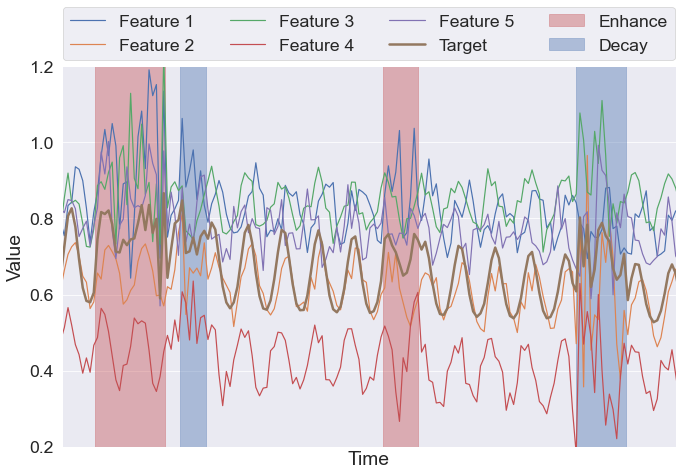

In [360]:
y_min = np.min(ts_anomaly_scaled[:,-1])-0.1
y_max = np.max(ts_anomaly_scaled[:,-1])+0.2
sns.set_theme(context='paper', font_scale=2)
plt.figure(figsize=(11, 7))
for i in range(5):
    plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, i], label= f'Feature {i+1}')
plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, -1], label= f'Target', linewidth=2.5)

plt.xlim((20000, 22500))
plt.ylim((0.2, 1.2))
label_flag=[1,1]
for params in params_configs:
    start_idx=params['start_idx']
    end_idx=params['end_idx']
    if params['increasing'] == 1:
        color='r'
        if label_flag[0]:
            label= f'Enhance'
            label_flag[0]=0
        else:
            label = '_nolegend_'
    else:
        color='b'
        if label_flag[1]:
            label= f'Decay'
            label_flag[1]=0
        else:
            label = '_nolegend_'
    plt.fill_between(np.arange(start_idx, end_idx), y_min, y_max, alpha=0.4, color=color, label=label)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=4)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('./data_on_exp_I_3.pdf', dpi=300, bbox_inches='tight')

In [113]:
anomalous_sample_counter = 0
for params_idx, params in enumerate(params_configs):
    anomalous_sample_counter += params['end_idx'] - params['start_idx']

share = anomalous_sample_counter*2/origin_ts.shape[0]
print(f'share of outliers over the second-year data: {share*100:.2f} %')

share of outliers over the second-year data: 15.98 %


##### Experiment I-4
- Type 4: alpha=0.005, beta=0.001, b=0  

In [322]:
NUM_ANOMALIES = 10  # Numbers of existing anomalies
CHANNELS=[0, 1, 2, 3, 4]  # on which input channels an anomaly happens
# The period of an anomaly ranges between half a day (12 hours) and 2 days (48 hours)
DURATION = np.arange(1440, 2160+1, 1)

anomaly_indices = anomalies_idx_generation(NUM_ANOMALIES, DURATION, int(noisy_ts_scaled.shape[0]/2))

In [323]:
params_configs=[]

for idx in range(NUM_ANOMALIES):
    selected_channels_num = np.random.choice(np.arange(2, 6), 1)

    # Type 4
    params={'index': idx,
            'affected_channels': np.sort(np.random.choice(CHANNELS, selected_channels_num, replace=False)),
            'anomaly_type': 4,
            'start_idx': anomaly_indices[idx][0],
            'end_idx': anomaly_indices[idx][-1],
            'alpha': 0.005,
            'beta': 0.001,
            'b': 0,
            'increasing': True,
           }
    params_configs.append(params)

In [324]:
warmup_length = int(origin_ts.shape[0]/2)
ts_anomaly_scaled = add_synthetic_anomalies(origin_ts_scaled[warmup_length:], params_configs, noise_X_scaled[warmup_length:], noise_y_scaled[warmup_length:])
ts_anomaly_scaled=np.concatenate((noisy_ts_scaled[:warmup_length], ts_anomaly_scaled), axis=0)

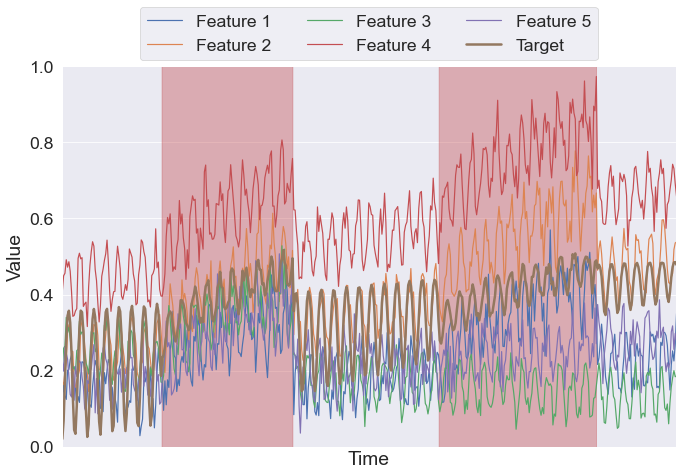

In [330]:
y_min = np.min(ts_anomaly_scaled[:,-1])-0.1
y_max = np.max(ts_anomaly_scaled[:,-1])+0.1
sns.set_theme(context='paper', font_scale=2)
plt.figure(figsize=(11, 7))
for i in range(5):
    plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, i], label= f'Feature {i+1}')
plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, -1], label= f'Target', linewidth=2.5)

plt.xlim((43000, 50000))
plt.ylim((-0.0, 1.0))
for params in params_configs:
    start_idx=params['start_idx']
    end_idx=params['end_idx']

    plt.fill_between(np.arange(start_idx, end_idx), -0.3, 1.2, alpha=0.4, color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Value')
plt.savefig('./data_on_exp_I_4.pdf', dpi=300, bbox_inches='tight')

In [191]:
anomalous_sample_counter = 0
for params_idx, params in enumerate(params_configs):
    anomalous_sample_counter += params['end_idx'] - params['start_idx']

share = anomalous_sample_counter*2/origin_ts.shape[0]
print(f'share of outliers over the second-year data: {share*100:.2f} %')

share of outliers over the second-year data: 31.84 %


##### Experiment I-5

In [331]:
def anomalies_idx_generation_recurrent(num_anomalies:list, num_samples):
    '''
    generate the indices of the selected type of the synthetic anomaly. The anomalies from the same pattern should be regular
    and recurrent (starting from the similar time point of a day).
    params:
        - num_anomalies: list, the amount of anmalous sequences of each pattern.
        - num_samples: int, the amount of samples in the given dataset where anomalies will be added.
    '''
    indices_samples = np.arange(num_samples)
    flag_anomalies = np.zeros_like(indices_samples)  # 0: no anomaly exists at the corresponding index

    anomaly_indices = []
    for idx, num in enumerate(num_anomalies):
        counter = 0
        if idx==3:
            # The duration of pattern 4 is between 10 days to 15 days
            duations_anomalies = np.random.choice(np.arange(1440, 2160+1, 1), num)
        else:
            # The duration of pattern 1, 2, 3 is between 12 hours to 48 hours
            duations_anomalies = np.random.choice(np.arange(72, 288+1, 1), num)
        
        while(counter<num):
            if idx == 0:
                # pattern 1 starts between 0 am to 6 am
                start_index = np.random.choice(int(num_samples/144), 1)[0]*144 + np.random.choice(np.arange(0, 36), 1)[0]
            if idx == 1:
                # pattern 2 starts between 6 am to 12 pm
                start_index = np.random.choice(int(num_samples/144), 1)[0]*144 + np.random.choice(np.arange(36, 72), 1)[0]
            if idx == 2:
                # pattern 3 starts between 12 pm to 18 pm
                start_index = np.random.choice(int(num_samples/144), 1)[0]*144 + np.random.choice(np.arange(72, 108), 1)[0]
            if idx == 3:
                # pattern 4 starts between 18 pm to 0 am
                start_index = np.random.choice(int(num_samples/144), 1)[0]*144 + np.random.choice(np.arange(108, 144), 1)[0]
            
            duration = duations_anomalies[counter]
            if sum(flag_anomalies[start_index:start_index+duration])==0 and start_index+duration<num_samples:
                flag_anomalies[start_index:start_index+duration] = 1
                anomaly_indices.append(np.arange(start_index,start_index+duration, 1))
                counter += 1
            
    return anomaly_indices

In [340]:
NUM_ANOMALIES = [15, 15, 15, 5]

anomaly_indices_recurrent = anomalies_idx_generation_recurrent(NUM_ANOMALIES, int(noisy_ts_scaled.shape[0]/2))

In [341]:
params_configs=[]
CHANNELS=[0, 1, 2, 3, 4]  # on which input channels an anomaly happens
counter_all = 0
for idx, num in enumerate(NUM_ANOMALIES):
    selected_channels_num = np.random.choice(np.arange(2, 6), 1)
    counter_single=0
    idx += 1
    if idx == 1:
        alpha=0.2
        beta=0.05
        b=0 # placeholder
        increasing=True # placeholder
    elif idx == 2:
        alpha=0.2
        beta=0.005
        b=0.005
        increasing=True # placeholder
    elif idx == 3:
        alpha=0.1
        beta=0.01
        b=0 # placeholder
        increasing=True
    elif idx == 4:
        alpha=0.005
        beta=0.001
        b=0
        increasing=True # placeholder
    while(counter_single<num):
        if idx==3:
            increasing = True if counter_single %2 ==0 else False
        params={'index': counter_all,
                'affected_channels': np.sort(np.random.choice(CHANNELS, selected_channels_num, replace=False)),
                'anomaly_type': idx,
                'start_idx': anomaly_indices_recurrent[counter_all][0],
                'end_idx': anomaly_indices_recurrent[counter_all][-1],
                'alpha': alpha,
                'beta': beta,
                'b': b,
                'increasing': increasing,
               }
        params_configs.append(params)
        counter_single += 1
    
        counter_all += 1

In [342]:
warmup_length = int(origin_ts.shape[0]/2)
ts_anomaly_scaled = add_synthetic_anomalies(origin_ts_scaled[warmup_length:], params_configs, noise_X_scaled[warmup_length:], noise_y_scaled[warmup_length:])
ts_anomaly_scaled = np.concatenate((noisy_ts_scaled[:warmup_length], ts_anomaly_scaled), axis=0)

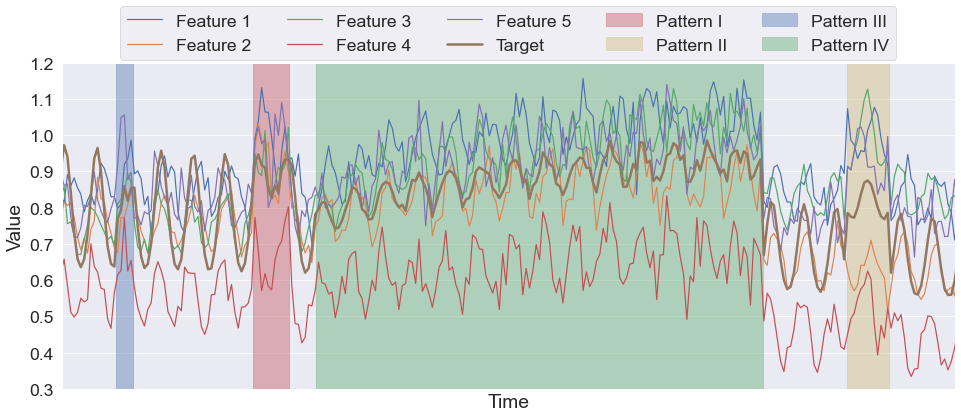

In [351]:
y_min = np.min(ts_anomaly_scaled[:,-1])-0.1
y_max = np.max(ts_anomaly_scaled[:,-1])+0.2
sns.set_theme(context='paper', font_scale=2)
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, i], label= f'Feature {i+1}')
plt.plot(np.arange(0, 52560, 15), ts_anomaly_scaled[warmup_length::15, -1], label= f'Target', linewidth=2.5)

plt.xlim((17000, 21000))
plt.ylim((0.3, 1.2))
label_flag=[1,1,1,1]
for params in params_configs:
    start_idx=params['start_idx']
    end_idx=params['end_idx']
    if params['anomaly_type'] == 1:
        color='r'
        pattern_idx = params['anomaly_type']
        if label_flag[pattern_idx-1]:
            label = f'Pattern I'
            label_flag[pattern_idx-1]=0
        else:
            label = '_nolegend_'
    elif params['anomaly_type'] == 2:
        color='y'
        pattern_idx = params['anomaly_type']
        if label_flag[pattern_idx-1]:
            label = f'Pattern II'
            label_flag[pattern_idx-1]=0
        else:
            label = '_nolegend_'
    elif params['anomaly_type'] == 3:
        color='b'
        pattern_idx = params['anomaly_type']
        if label_flag[pattern_idx-1]:
            label = f'Pattern III'
            label_flag[pattern_idx-1]=0
        else:
            label = '_nolegend_'
    elif params['anomaly_type'] == 4:
        color='g'
        pattern_idx = params['anomaly_type']
        if label_flag[pattern_idx-1]:
            label = f'Pattern IV'
            label_flag[pattern_idx-1]=0
        else:
            label = '_nolegend_'    
    plt.fill_between(np.arange(start_idx, end_idx), y_min, y_max, alpha=0.4, color=color, label=label)
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.savefig('./data_on_exp_I_5.pdf', dpi=300, bbox_inches='tight')